## Retrieve data from API

In [6]:
import requests # to download data
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import scipy.stats

**Overview: Yearly summary of total records from March, 2015- March, 2023**



In [7]:

OPENFDA_API = "https://api.fda.gov/drug/event.json?sort=receivedate:desc"

def call_api(params):
    if not params:
        params = {}
    params['limit'] = params.get('limit', 1000)
    response = requests.get(OPENFDA_API, params=params)
    # print(response.url)

    if response.status_code != 200:
        raise Exception('API response: {}'.format(response.status_code))
    
    return response.json()['results']



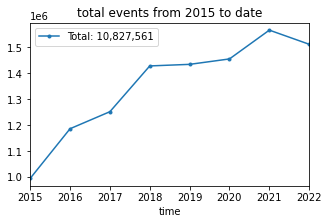

In [8]:
#total events from 2015 to date
ref = pd.DataFrame(
    call_api({
        'count':'receivedate',
        'search': 'receivedate:[20150301 TO 20230301]'}))
ref.index = pd.to_datetime(ref.time)
# recrod reports by year
ref.drop('time', axis=1).resample("y").sum().plot(style='.-', figsize=(5, 3))
total = ref['count'].sum()
plt.gca().legend(["Total: {:,}".format(total)])
plt.title("total events from 2015 to date")
plt.show()


**Retrive the lastest 26000 records from the API (maximum limit)**
    

In [9]:
cdc_df=[]
n_query_per_iter=1000
page_num=26
URL = "https://api.fda.gov/drug/event.json?sort=receivedate:desc"
for i in range(page_num):
  param={'skip': i*n_query_per_iter, 
          'limit': n_query_per_iter}
  response = requests.get(url=URL,params=param)

  if response.status_code == 200:
    cdc_df.extend(response.json()['results'])
cdc_df=pd.DataFrame(cdc_df)

**Overview: Yearly summary of total 10 active substance & side effect from March, 2015- March, 2023**
change the charts to using current data [-]

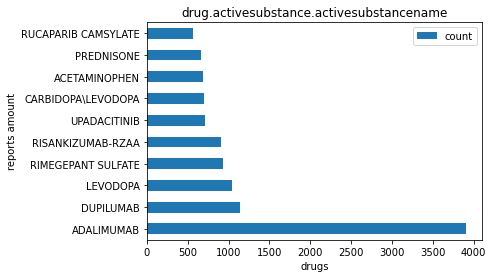

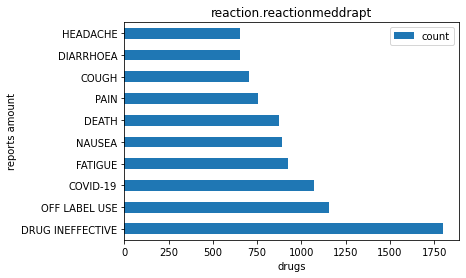

In [6]:
##要改！！！
properties=['drug.activesubstance.activesubstancename',"reaction.reactionmeddrapt"]
for i in properties: 
    df_ref = pd.DataFrame(call_api({"count":"patient."+ i+ ".exact",
                                    'search': 'receivedate:[20221226 TO 20231231]'}))
# Create a pie chart
    df_ref[0:10].plot.barh('term', 'count')
    plt.xlabel("drugs")
    plt.ylabel("reports amount")
    plt.title(i)



In [41]:

cdc_df.shape #(26000, 27)



(26000, 27)

In [43]:
cdc_df.columns

Index(['safetyreportversion', 'safetyreportid', 'primarysourcecountry',
       'occurcountry', 'transmissiondateformat', 'transmissiondate',
       'reporttype', 'serious', 'seriousnessdeath',
       'seriousnesslifethreatening', 'seriousnesshospitalization',
       'seriousnessdisabling', 'seriousnesscongenitalanomali',
       'seriousnessother', 'receivedateformat', 'receivedate',
       'receiptdateformat', 'receiptdate', 'fulfillexpeditecriteria',
       'companynumb', 'duplicate', 'reportduplicate', 'primarysource',
       'sender', 'receiver', 'patient', 'authoritynumb'],
      dtype='object')

## Data Wrangling

In [10]:

new=pd.json_normalize(cdc_df.patient,max_level=4)

In [9]:
new

,reaction,drug,summary.narrativeincludeclinical,patientsex,patientonsetage,patientonsetageunit,patientagegroup,patientweight
0,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20200101,NaN,NaN,NaN,NaN,NaN
1,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221201,2,NaN,NaN,NaN,NaN
2,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,2,NaN,NaN,NaN,NaN
3,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221208,1,40,801,5,NaN
4,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
25995,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20140522,2,36,801,NaN,49.5
25996,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221129,1,65,801,NaN,108
25997,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221225,2,59,801,NaN,117.45
25998,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221212,0,34,801,NaN,NaN


In [13]:
new["country"]=cdc_df.occurcountry
# 1 indicates adverse event
new["death"]=cdc_df.seriousnessdeath
new["disability"]=cdc_df.seriousnessdisabling
new["hospitalization"]=cdc_df.seriousnesshospitalization
new["lifethreatening"]=cdc_df.seriousnesslifethreatening
new['other']=cdc_df.seriousnessother
new["congenital_anomaly"]=cdc_df.seriousnesscongenitalanomali

In [11]:
new.country.unique()

array(['CA', 'JP', 'US', 'TW', 'NL', 'GB', 'FR', 'IT', 'CL', 'BE', 'IN',
       'PT', 'IL', 'DE', 'CZ', 'ES', 'KE', 'AU', 'PL', 'BR', 'RU', 'EG',
       'CH', 'SE', nan, 'CO', 'AR', 'AT', 'QA', 'KR', 'MX', 'SA', 'TR',
       'HU', 'CN', 'RO', 'IE', 'PR', 'BG', 'GR', 'LT', 'NO', 'JM', 'HR',
       'BY', 'RS', 'UY', 'NZ', 'IR', 'DO', 'DK', 'SK', 'PH', 'SI', 'TH',
       'VN', 'SG', 'MY', 'ZA', 'UA', 'FI', 'GT', 'LK', 'NP', 'TN', 'A1',
       'LB', 'CR', 'KW', 'AE', 'BA', 'PK', 'UG', 'NG', 'UZ', 'ZW', 'DZ',
       'PA', 'PE', 'SY', 'ID', 'AF', 'MK', 'JO', 'BF', 'KZ', 'IQ', 'SV',
       'HN', 'ET', 'HK', 'MA', 'CY', 'MT', 'ML', 'CM', 'TZ', 'BD'],
      dtype=object)

**analyze top_ten_side_effect in 2022 one week**

In [14]:
new['side_effects']=None
for i in range(len(new.reaction)):
  lst=[]
  for row in new.reaction[i]:
      if row['reactionmeddrapt'] not in lst:
        lst.append(row['reactionmeddrapt'])
  new['side_effects'][i]=lst 


total_sympt=[]
for i in new.side_effects:
  total_sympt=total_sympt+i


top_ten_total_sympt=pd.Series(total_sympt).value_counts()[:10].index.to_list()
top_ten_total_sympt
#Patient reaction, as a MedDRA term. For instance, diarrhea is spelled diarrohea. MedDRA is a standardized medical terminology.
pd.Series(total_sympt).value_counts()[:].sum()


64746

In [15]:
eff=pd.Series(total_sympt).value_counts()
eff.values[0:10]

array([1800, 1158, 1073,  923,  889,  872,  751,  702,  654,  652])

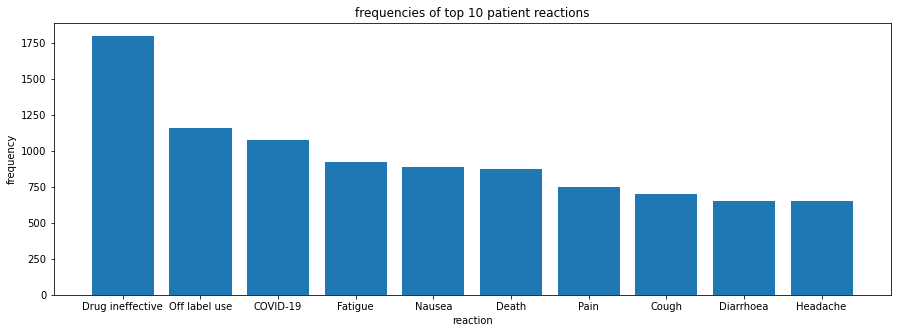

In [16]:
# frequencies of patient reaction
fig, ax = plt.subplots(figsize=(15,5))

# Create a column chart
ax.bar(eff.index[0:10],eff.values[0:10] )

# Set the title and axis labels
ax.set_title('frequencies of top 10 patient reactions')
ax.set_xlabel('reaction')
ax.set_ylabel('frequency')



# Show the chart
plt.show()

In [17]:
s2=pd.Series(total_sympt).value_counts().sum() # #46629
s1=pd.Series(total_sympt).value_counts()[:10].sum() #7457
print(f"Porportion_reaction: the total percentage of top 10 adverse reactions among all the reaaction report records is {s1*100/s2:.3f}%")


Porportion_reaction: the total percentage of top 10 adverse reactions among all the reaaction report records is 14.633%


**analyze top_ten_drug**

In [18]:
# analyze top_ten_drug:
new['med']=None
for i in range(len(new.drug)):
  lst=[]
  for row in new.drug[i]:
      if row['medicinalproduct'] not in lst:
        lst.append(row['medicinalproduct'])
  new['med'][i]=lst      

total_med=[]
for i in new.med:
  total_med=total_med+i

top_ten_drugs=pd.Series(total_med).value_counts()[:10].index.to_list()
top_ten_drugs




['HUMIRA',
 'DUPIXENT',
 'INBRIJA',
 'NURTEC ODT',
 'SKYRIZI',
 'RINVOQ',
 'PREDNISONE',
 'RUBRACA',
 'ASPIRIN',
 'PAXLOVID']

In [20]:
drug=pd.Series(total_med).value_counts()


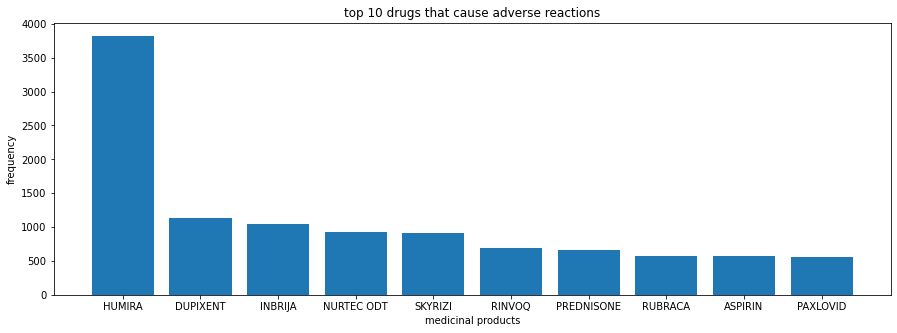

In [21]:
# top 10 drugs that cause adverse reactions
fig, ax = plt.subplots(figsize=(15,5))

# Create a column chart
ax.bar(drug.index[0:10],drug.values[0:10] )

# Set the title and axis labels
ax.set_title('top 10 drugs that cause adverse reactions')
ax.set_xlabel('medicinal products')
ax.set_ylabel('frequency')


# Show the chart
plt.show()

In [22]:

n1=pd.Series(total_med).value_counts()[:10].sum() #9636
n2=pd.Series(total_med).value_counts().sum()  #44011
print(f"Porportion_drug: the total % of top ten durg among all the drug records is {n1*100/n2:.4f}%")


Porportion_drug: the total % of top ten durg among all the drug records is 16.4678%


In [23]:
#create dummy variables for the drugs
for d in top_ten_drugs:
  new[f'drug_{d}']=0

new['other_drug']=0



In [24]:
for idx in range(len(new.med)):
  for i in new.med[idx]:
    if i not in top_ten_drugs:
      new['other_drug'][idx]+=1
    else:
      new[f'drug_{i}'][idx]+=1
      if new[f'drug_{i}'][idx]>1:
        new[f'drug_{i}'][idx]=1
  if new['other_drug'][idx]>1:
    new['other_drug'][idx]=1
  

/var/folders/9k/znvz547n28q5p5rm8qtkt5w80000gn/T/ipykernel_86480/372038992.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['other_drug'][idx]+=1
/var/folders/9k/znvz547n28q5p5rm8qtkt5w80000gn/T/ipykernel_86480/372038992.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new[f'drug_{i}'][idx]+=1
/var/folders/9k/znvz547n28q5p5rm8qtkt5w80000gn/T/ipykernel_86480/372038992.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['o

In [25]:
new['serious_results']=cdc_df['serious']


In [26]:
new

,reaction,drug,summary.narrativeincludeclinical,patientsex,patientonsetage,patientonsetageunit,patientagegroup,patientweight,country,death,...,drug_INBRIJA,drug_NURTEC ODT,drug_SKYRIZI,drug_RINVOQ,drug_PREDNISONE,drug_RUBRACA,drug_ASPIRIN,drug_PAXLOVID,other_drug,serious_results
0,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20200101,NaN,NaN,NaN,NaN,NaN,CA,2,...,0,0,0,0,1,0,0,0,1,1
1,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221201,2,NaN,NaN,NaN,NaN,JP,2,...,0,0,0,0,0,0,0,0,0,1
2,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,2,NaN,NaN,NaN,NaN,US,2,...,0,0,0,0,0,0,0,0,1,2
3,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221208,1,40,801,5,NaN,TW,2,...,0,0,0,0,0,0,0,0,1,1
4,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,1,NaN,NaN,NaN,NaN,US,2,...,0,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25995,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20140522,2,36,801,NaN,49.5,NaN,2,...,0,0,0,0,0,0,0,0,1,1
25996,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221129,1,65,801,NaN,108,NaN,2,...,0,0,0,0,0,0,0,0,1,1
25997,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221225,2,59,801,NaN,117.45,NaN,2,...,0,0,0,0,0,0,0,0,1,1
25998,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221212,0,34,801,NaN,NaN,NaN,2,...,0,0,0,0,0,0,0,0,1,1


## EDA

In [27]:
new.patientweight.isna().sum()
#most weight is missing so we drop it (limited data)
new.shape #(19062, 27)
new.patientagegroup.value_counts()



5    3213
6    2032
4     188
3     169
1      75
2      24
Name: patientagegroup, dtype: int64

- (1.1)EDA: Missing value siginificantly for patientagegroup/patientweight/patientonsetageunit

patientweight                       86.769231
patientagegroup                     78.073077
summary.narrativeincludeclinical    60.800000
patientonsetage                     50.265385
patientonsetageunit                 50.265385
patientsex                          11.865385
country                              8.376923
congenital_anomaly                   7.519231
disability                           7.476923
death                                7.215385
lifethreatening                      6.992308
hospitalization                      5.903846
other                                5.526923
drug_SKYRIZI                         0.000000
other_drug                           0.000000
drug_PAXLOVID                        0.000000
drug_ASPIRIN                         0.000000
drug_RUBRACA                         0.000000
drug_PREDNISONE                      0.000000
drug_RINVOQ                          0.000000
reaction                             0.000000
drug_NURTEC ODT                   

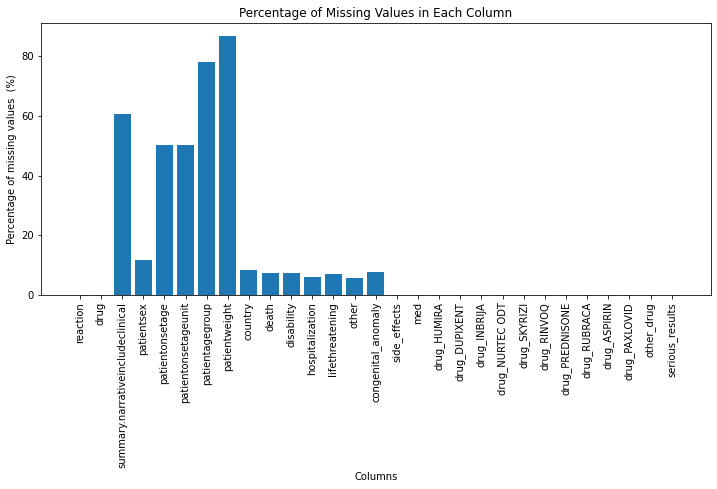

In [28]:
percent_mis = new.isna().sum() * 100 / len(new)
print(percent_mis.sort_values(ascending=False))

plt.figure(figsize=(12,5))
plt.bar(percent_mis.index, percent_mis.values)
plt.xlabel('Columns')
plt.ylabel('Percentage of missing values  (%)')
plt.title('Percentage of Missing Values in Each Column')
plt.xticks(rotation=90)
plt.show()

In [29]:
df_copy=new.copy()
df_copy =df_copy.drop(["reaction","drug","patientweight","patientagegroup","summary.narrativeincludeclinical", "patientonsetageunit"], axis = 1)
df_copy = df_copy[(df_copy['patientsex']!="0")]
df_copy


,patientsex,patientonsetage,country,death,disability,hospitalization,lifethreatening,other,congenital_anomaly,side_effects,...,drug_INBRIJA,drug_NURTEC ODT,drug_SKYRIZI,drug_RINVOQ,drug_PREDNISONE,drug_RUBRACA,drug_ASPIRIN,drug_PAXLOVID,other_drug,serious_results
0,NaN,NaN,CA,2,1,2,2,2,2,"[Migraine, Visual impairment, Off label use, I...",...,0,0,0,0,1,0,0,0,1,1
1,2,NaN,JP,2,2,2,2,1,2,"[Chronic eosinophilic rhinosinusitis, Conditio...",...,0,0,0,0,0,0,0,0,0,1
2,2,NaN,US,2,2,2,2,2,2,"[Paraesthesia, Hypoaesthesia, Sensory disturba...",...,0,0,0,0,0,0,0,0,1,2
3,1,40,TW,2,2,1,2,2,2,"[Cholelithiasis, Cholecystitis]",...,0,0,0,0,0,0,0,0,1,1
4,1,NaN,US,2,2,2,2,2,2,"[Hypoaesthesia, Anxiety, Feeling cold, Restles...",...,0,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25994,2,49,NaN,2,2,1,2,2,2,[Lipase increased],...,0,0,0,0,0,0,0,0,1,1
25995,2,36,NaN,2,1,2,2,2,2,"[Gallbladder disorder, Therapy cessation]",...,0,0,0,0,0,0,0,0,1,1
25996,1,65,NaN,2,2,2,2,1,2,"[Product substitution issue, Therapeutic respo...",...,0,0,0,0,0,0,0,0,1,1
25997,2,59,NaN,2,1,2,2,2,2,"[Application site rash, Application site eryth...",...,0,0,0,0,0,0,0,0,1,1


In [30]:
df_copy.shape

(25920, 23)

In [31]:
# df_copy = df_copy[(df_copy['patientsex'].notna())& (df_copy['patientsex']!="0")]
# df_copy.patientsex.value_counts()
# # 1 = Male
# 2 = Female
df_copy.loc[df_copy['patientsex'] == '1', 'patientsex'] = 'Male'
df_copy.loc[df_copy['patientsex'] == '2', 'patientsex'] = 'Female'
df_copy.loc[df_copy['death'] == '2', 'death'] = 0
df_copy.loc[df_copy['lifethreatening'] == '2', 'lifethreatening'] = 0
df_copy.loc[df_copy['congenital_anomaly'] == '2', 'congenital_anomaly'] = 0
df_copy.loc[df_copy['hospitalization'] == '2', 'hospitalization'] = 0
df_copy.loc[df_copy['disability'] == '2', 'disability'] = 0

- (1.2) patient Approximately 60% of reports are for females and 40% are for males among "death", 
    "disability", "lifethreatening","serious_results". Sex could be an important confounding factor as well and a reporting bias may skew the results based on the histagram. 

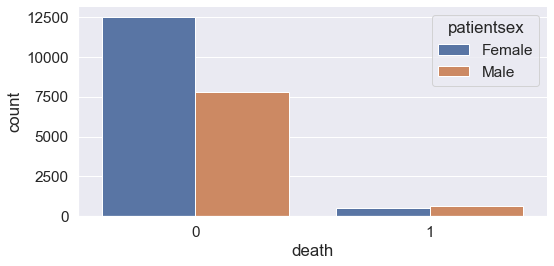

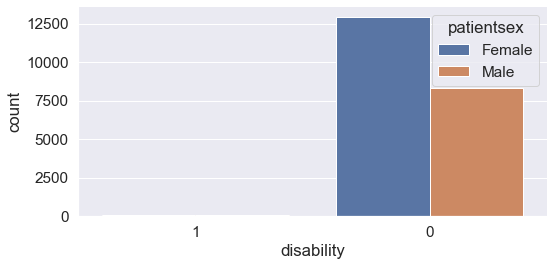

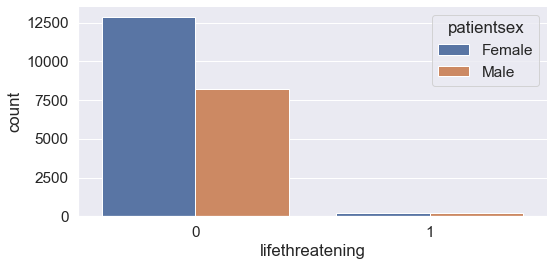

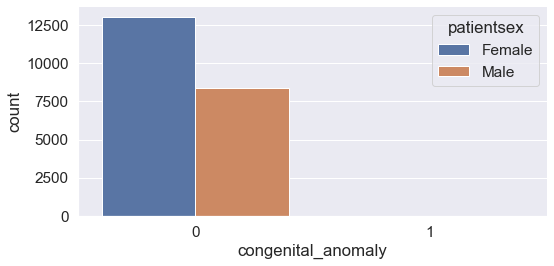

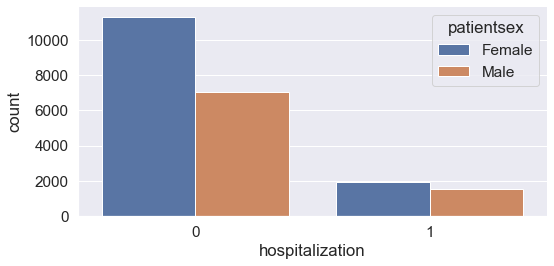

In [32]:
c = ["death", "disability", "lifethreatening","congenital_anomaly","hospitalization"]
sns.set(font_scale = 1.4)

for i, col_name in enumerate(c):
    sns.catplot(x = col_name, hue = 'patientsex', kind = 'count', data = df_copy, height = 4, aspect = 2, legend_out = False)
plt.show()


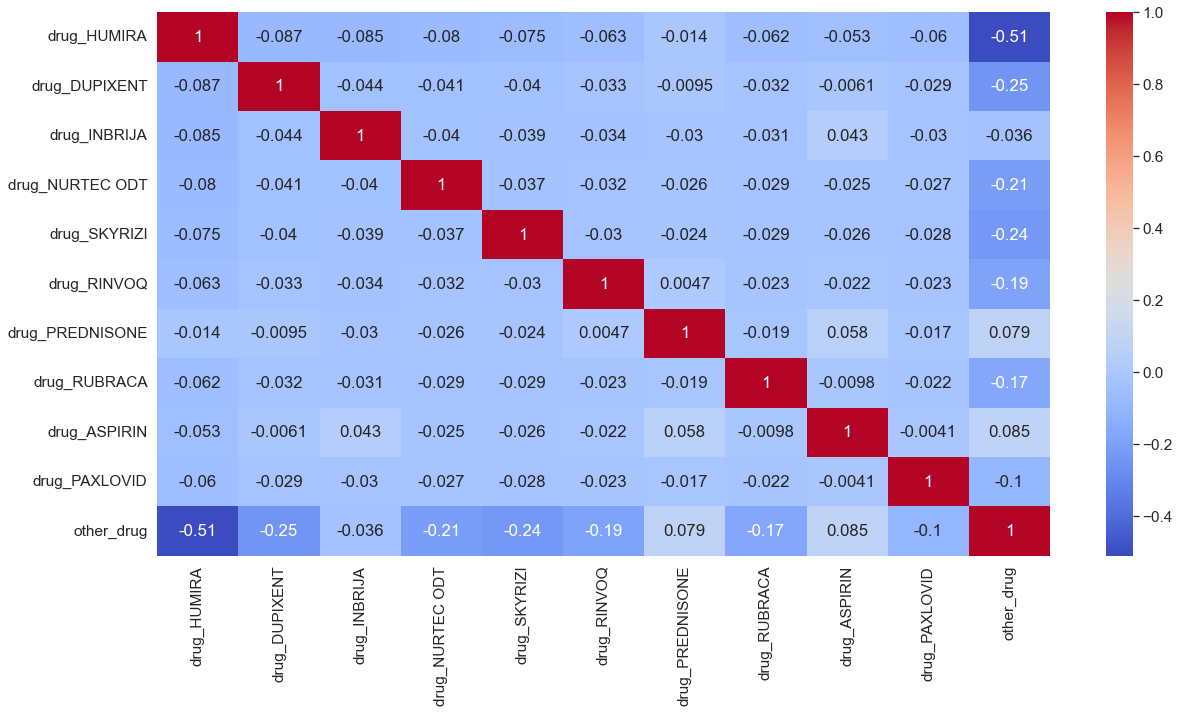

In [33]:
import seaborn as sns
cor=df_copy.corr()
# Generate a heatmap from the correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True, cmap="coolwarm")

# Show the plot

plt.show()

**Number of Patients with serious side effects by country**

Text(0, 0.5, 'frequency')

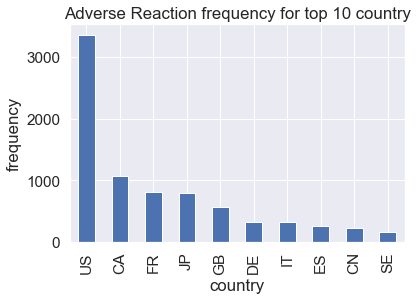

In [34]:
df_serious=df_copy.loc[df_copy['serious_results'] == "1"]
df_serious.country.value_counts().sort_values(ascending=False)[:10].plot(kind='bar')
plt.title("Adverse Reaction frequency for top 10 country")
plt.xlabel('country')
plt.ylabel('frequency')


## data modelling


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [39]:
reg=df_copy.dropna(subset=['patientonsetage','patientsex','serious_results'])
reg['patientonsetage']=reg['patientonsetage'].astype(int)
reg.isna().sum()



/var/folders/9k/znvz547n28q5p5rm8qtkt5w80000gn/T/ipykernel_86480/3641226437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['patientonsetage']=reg['patientonsetage'].astype(int)


patientsex               0
patientonsetage          0
country               1421
death                 1048
disability            1104
hospitalization        763
lifethreatening       1001
other                  728
congenital_anomaly    1113
side_effects             0
med                      0
drug_HUMIRA              0
drug_DUPIXENT            0
drug_INBRIJA             0
drug_NURTEC ODT          0
drug_SKYRIZI             0
drug_RINVOQ              0
drug_PREDNISONE          0
drug_RUBRACA             0
drug_ASPIRIN             0
drug_PAXLOVID            0
other_drug               0
serious_results          0
dtype: int64

In [40]:
reg.serious_results.value_counts()

1    6923
2    5655
Name: serious_results, dtype: int64

In [41]:
reg['serious_results']=[0 if i=="2" else 1 for i in reg['serious_results']]
reg.serious_results.value_counts()

/var/folders/9k/znvz547n28q5p5rm8qtkt5w80000gn/T/ipykernel_86480/2271150789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['serious_results']=[0 if i=="2" else 1 for i in reg['serious_results']]


1    6923
0    5655
Name: serious_results, dtype: int64

In [42]:
#assign dummy variable to patient sex
reg['patientsex']=[0 if i=="Male" else 1 for i in reg['patientsex']]

/var/folders/9k/znvz547n28q5p5rm8qtkt5w80000gn/T/ipykernel_86480/3963524969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['patientsex']=[0 if i=="Male" else 1 for i in reg['patientsex']]


In [77]:
reg['patientsex'] = reg['patientsex'].astype(str).astype(int)
# standardize the age column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(reg[['patientonsetage']])
reg['age_standardized'] = scaler.transform(reg[['patientonsetage']])

/var/folders/9k/znvz547n28q5p5rm8qtkt5w80000gn/T/ipykernel_86480/4063860745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['patientsex'] = reg['patientsex'].astype(str).astype(int)
/var/folders/9k/znvz547n28q5p5rm8qtkt5w80000gn/T/ipykernel_86480/4063860745.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['age_standardized'] = scaler.transform(reg[['patientonsetage']])


In [79]:
#train-test split: using stratify
X = reg[['age_standardized', 'patientsex', 'drug_HUMIRA', 'drug_DUPIXENT', 'drug_INBRIJA','drug_NURTEC ODT',\
         'drug_SKYRIZI','drug_RINVOQ','drug_PREDNISONE','drug_RUBRACA','drug_PAXLOVID','drug_ASPIRIN','other_drug'
         ]]
y = reg['serious_results']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, random_state=0, train_size=0.8)
#Sort by index and drop new coloumn created by the preprocessing


# # standardize the age column
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(reg[['patientonsetage']])
# reg['age_standardized'] = scaler.transform(reg[['patientonsetage']])
# reg[['patientonsetage','age_standardized']]


**logistic regression**

In [80]:
#predict the chance of getting serious side effects
from  sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [81]:
prediction = logistic_regression.predict(X_test)
RMSE_on_test=np.mean((prediction - y_test)**2)**0.5
RMSE_on_test


0.5059267182084163

In [82]:

# cross_val_score


from sklearn.model_selection import cross_val_score
logr_cv_scores = cross_val_score(LogisticRegression(),X_train, y_train,cv=5)

# Print out the mean cv accuracy for the LogisticRegression model
print(f'logr mean cv accuracy: {logr_cv_scores.mean():0.2f}')
logr_cv_scores

logr mean cv accuracy: 0.73


array([0.73720815, 0.72478887, 0.7360835 , 0.73310139, 0.74105368])

In [83]:
#predict the chance of getting serious side effects

print("Coefficients: ", logistic_regression.coef_)
print("Intercept: ", logistic_regression.intercept_)



Coefficients:  [[-0.27568572 -0.32166128 -2.06789402 -2.56803361 -4.24734116 -3.94536661
  -2.24313274 -1.38135498  1.57360193 -1.54389716 -2.28846858  0.93440256
   0.33316253]]
Intercept:  [0.57452534]


Precision:  0.7959596721584106
F1 score:  0.7174350989977455
              precision    recall  f1-score   support

           0       0.90      0.49      0.63      1131
           1       0.69      0.95      0.80      1385

    accuracy                           0.74      2516
   macro avg       0.80      0.72      0.72      2516
weighted avg       0.79      0.74      0.73      2516



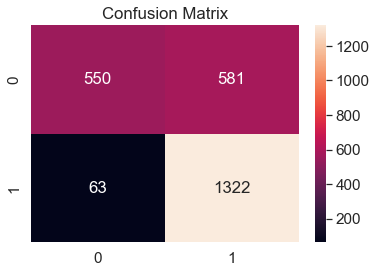

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)



precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
print("Precision: ", precision)

f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
print("F1 score: ", f1)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support



prfs=precision_recall_fscore_support(y_test, y_pred, average="macro")
prfs
cf=confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix")
plt.show()

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,r2_score

# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the performance metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1)
print("R-squared:", r2)

Accuracy:  0.7440381558028617
Precision:  0.6946925906463479
Recall:  0.9545126353790614
F1 score:  0.8041362530413626
R-squared: -0.0343895533488463


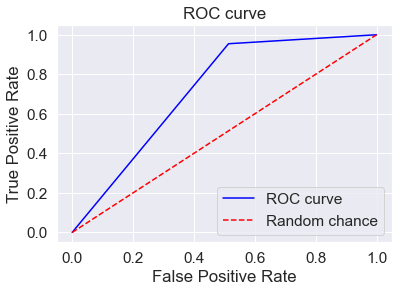

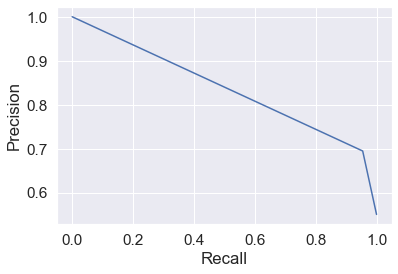

In [86]:
#model evaluation

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve,auc


# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Plot the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

**Decision Tree**

              precision    recall  f1-score   support

           0       0.84      0.50      0.62      1131
           1       0.69      0.92      0.79      1385

    accuracy                           0.73      2516
   macro avg       0.76      0.71      0.71      2516
weighted avg       0.76      0.73      0.72      2516

dev_acc_decision_tree is 0.7531
test_acc_decision_tree is 0.7305
Accuracy_decison_tree : 0.731
F1 score_decision_tree : 0.790


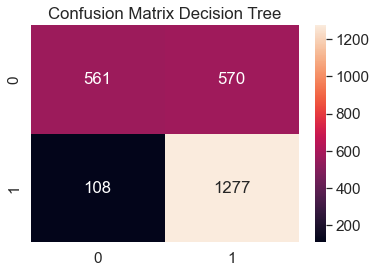

In [138]:
#fit a decision tree on the X_train dataset 
from sklearn.tree import DecisionTreeRegressor
#X_1 and y_1 drops other drug
X_1 = reg[['age_standardized', 'patientsex', 'drug_HUMIRA', 'drug_DUPIXENT', 'drug_INBRIJA','drug_NURTEC ODT',\
         'drug_SKYRIZI','drug_RINVOQ','drug_PREDNISONE','drug_RUBRACA','drug_PAXLOVID','drug_ASPIRIN'
         ]]
y_1 = reg['serious_results']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, random_state=0, train_size=0.8)
dtc = DecisionTreeClassifier(random_state=0,criterion='entropy')
dtc.fit(X_train, y_train)
#get the prediction result for dev and test 
y_pred_dev=dtc.predict(X_train)
y_pred_dev
y_pred_test=dtc.predict(X_test)
y_pred_test


dev_acc=sum(np.where(y_pred_dev==y_train,1,0))/y_train.shape[0]
test_acc = sum(np.where(y_pred_test == y_test, 1, 0))/y_test.shape[0]


print(classification_report(y_test, y_pred_test))
from sklearn.metrics import f1_score
print(f'dev_acc_decision_tree is {dev_acc:.4f}')
dev_acc
print(f'test_acc_decision_tree is {test_acc:.4f}')
test_acc

#accuracy, F-1 score:
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy_decison_tree : {accuracy:.3f}")
f1=f1_score(y_test, y_pred_test)
print(f"F1 score_decision_tree : {f1:.3f}")
cf=confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix Decision Tree")
plt.show()


In [139]:
#### with max_depth 7: value increase of 0.03%


from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn import tree

dtc1 = DecisionTreeClassifier(random_state=0,criterion='entropy',max_depth=7)
dtc1.fit(X_train, y_train)
#get the prediction result for dev and test 
y_pred_dev=dtc1.predict(X_train)
y_pred_dev
y_pred_test1=dtc1.predict(X_test)
y_pred_test1

print(classification_report(y_test, y_pred_test1))

#accuracy, F-1 score:
accuracy1 = accuracy_score(y_test, y_pred_test1)
print(f"Accuracy_decison_tree : {accuracy1:.3f}")
f1=f1_score(y_test, y_pred_test1)
print(f"F1 score_decision_tree : {f1:.3f}")


              precision    recall  f1-score   support

           0       0.90      0.46      0.61      1131
           1       0.68      0.96      0.80      1385

    accuracy                           0.73      2516
   macro avg       0.79      0.71      0.70      2516
weighted avg       0.78      0.73      0.71      2516

Accuracy_decison_tree : 0.734
F1 score_decision_tree : 0.798


In [119]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 6,7,8],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the Decision Tree classifier
dtree = DecisionTreeClassifier()

# Instantiate the Grid Search CV object
grid_search = GridSearchCV(dtree, param_grid, cv=5)

# Fit the Grid Search CV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

best_cl=DecisionTreeClassifier(max_depth=grid_search.best_params_['max_depth'],
                                     min_samples_split=grid_search.best_params_['min_samples_split'],
                                     min_samples_leaf=grid_search.best_params_['min_samples_leaf'])
best_cl.fit(X_train, y_train)
y_pred_best=best_cl.predict(X_test)

f1=f1_score(y_test, y_pred_best)
print(f"F1 score_decision_tree : {f1:.3f}")
accuracy1 = accuracy_score(y_test, y_pred_best)
print(f"Accuracy_decison_tree : {accuracy1:.3f}")

{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
F1 score_decision_tree : 0.798
Accuracy_decison_tree : 0.733


In [ ]:
plt.figure(figsize = (12, 7))
tree.plot_tree(dtc1, max_depth = 7)

['other_drug', 'drug_INBRIJA', 'drug_PAXLOVID', 'drug_NURTEC ODT']


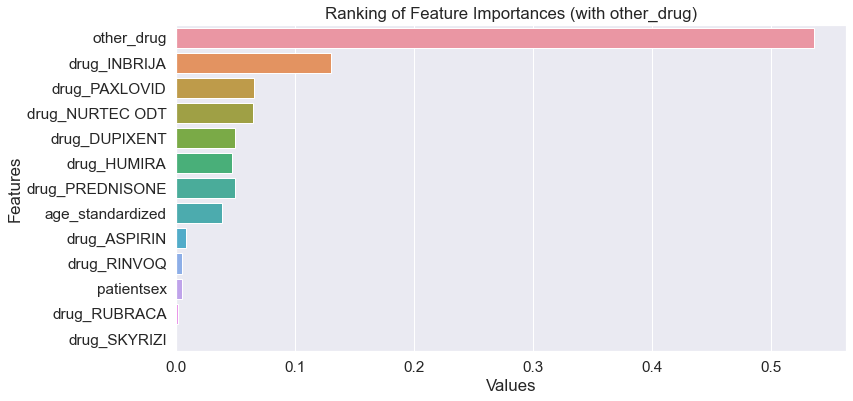

In [121]:
import numpy as np
indices = np.argsort(best_cl.feature_importances_)[::-1]
sorted_features = [X_train.columns.values[i] for i in indices]
sorted_importances = [dtc1.feature_importances_[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(y=sorted_features,x=sorted_importances)
plt.xticks(rotation=0)
plt.ylabel("Features")
plt.xlabel("Values")
plt.title ("Ranking of Feature Importances (with other_drug)")
print(sorted_features[:4])

**Prune tree to get best parameters**

In [140]:


path = dtc1.cost_complexity_pruning_path(X_train, y_train)
alphas = path['ccp_alphas']

len(alphas)
from sklearn import tree
alphas = path['ccp_alphas']

# alphas = alphas[250:450]
best_clf = None
best_acc_score = 0.0
best_alpha = None
for i in alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha = i, random_state = 0)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    test_acc = sum(np.where(y_pred == y_test, 1, 0))/y_test.shape[0]
    
    if test_acc > best_acc_score:
        best_acc_score = test_acc
        best_clf = clf
        best_alpha = i

print("Best Test Set Accuracy at alpha {} : {:0.4f}".format(best_alpha, best_acc_score))
print("At this alpha, the max depth is    : {}".format(best_clf.tree_.max_depth))

Best Test Set Accuracy at alpha 0.0004505367854224546 : 0.7397
At this alpha, the max depth is    : 14


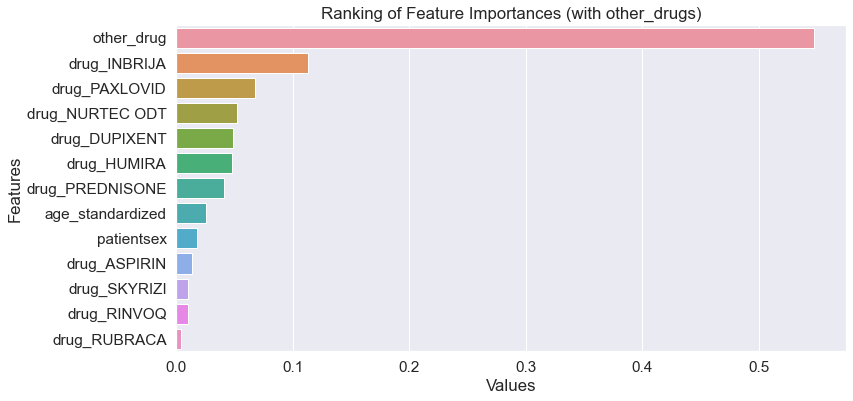

In [141]:
# Sort features and importances in descending order of importance
indices = np.argsort(best_clf.feature_importances_)[::-1]
features=X_train.columns.values
sorted_features = [features[i] for i in indices]
sorted_importances = [best_clf.feature_importances_[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(y=sorted_features, x=sorted_importances)
plt.xticks(rotation=0)
plt.ylabel("Features")
plt.xlabel("Values")
plt.title ("Ranking of Feature Importances (with other_drugs)")
plt.show()

**Model: Random Forest**

In [142]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 50}
Random Forest Accuracy: 0.733704292527822
Random Forest MSE: 0.26629570747217807
Random Forest R-Square: -0.07615062227286806
Precision:  0.6859074362974519
Recall:  0.9523465703971119
F1 score:  0.7974607013301087
XGBoost accuracy: 0.733704292527822


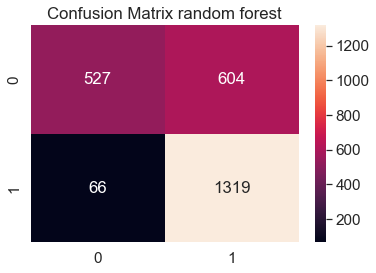

In [127]:

from sklearn.model_selection import GridSearchCV
param_grid ={'n_estimators': [25, 50, 100,150], 'max_depth': [2, 3, 4], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3]}


dforest = RandomForestClassifier()

# Instantiate the Grid Search CV object
grid_search = GridSearchCV(dforest, param_grid, cv=5)

# Fit the Grid Search CV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

best_rf=RandomForestClassifier(max_depth=4,min_samples_leaf=1,min_samples_split=2,n_estimators=150)
best_rf.fit(X_train, y_train)
y_pred_rf1 = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf1)
rf_mse = mean_squared_error(y_test, y_pred_rf1)
rf_r2 = r2_score(y_test, y_pred_rf1)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest MSE:", rf_mse)
print("Random Forest R-Square:", rf_r2)
print("Precision: ", precision_score(y_test, y_pred_rf1))
print("Recall: ", recall_score(y_test, y_pred_rf1))
print("F1 score: ", f1_score(y_test, y_pred_rf1))

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support



prfs=precision_recall_fscore_support(y_test, y_pred_rf1, average="macro")
prfs
cf=confusion_matrix(y_test, y_pred_rf1)
xgb_accuracy=accuracy_score(y_test, y_pred_rf1)
print("XGBoost accuracy:", xgb_accuracy)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix random forest")
plt.show()

**KNN classifier**

In [130]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)
print("KNN Accuracy:", knn_accuracy)
print("KNN MSE:", knn_mse)
print("KNN R-Square:", knn_r2)
print("Precision: ", precision_score(y_test, y_pred_knn))
print("Recall: ", recall_score(y_test, y_pred_knn))
print("F1 score: ", f1_score(y_test, y_pred_knn))

Random Forest Accuracy: 0.7325119236883942
Random Forest MSE: 0.2674880763116057
Random Forest R-Square: -0.0809692071487167
Precision:  0.6913978494623656
Recall:  0.9285198555956679
F1 score:  0.7926040061633283
